In [1]:
from typing import Optional
import pdb
import numpy as np
import torch
import matplotlib.pyplot as plt

## A few utility functions, taken from [here](https://github.com/bmild/nerf/blob/master/tiny_nerf.ipynb)

---



In [2]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.
  
  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.
  
  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [3]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.
  
  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. We randomly sample points along each ray, while trying to ensure most parts of the ray's trajectory are spanned.

In [4]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".
  
  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  return query_points, depth_values

#### Volume rendering


In [5]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  
  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """

  # shifted softplus activation, see Mip-NeRF for explanation
  # https://arxiv.org/abs/2103.13415
  sigma_a = torch.nn.functional.softplus(radiance_field[..., 3] - 1) # 

  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

## NeRF: Network architecture

In [6]:
class TinyVoxelNerf(torch.nn.Module):
  def __init__(self, filter_size=64,num_channels=32, encoding_dim=32):
    super(TinyVoxelNerf, self).__init__()



    # Register the "voxel" parameters, (C,D,H,W)
    self.register_parameter('voxel', torch.nn.Parameter(torch.randn([num_channels,64,64,64]),
                                                     requires_grad=True))
    # Unlike Direct Voxel Grid Optimisation, store RGB and Depth as one voxel feature
    
    # Layers to convert stored voxel feature to RGB-D
    self.layers=torch.nn.Sequential(
        torch.nn.Linear(num_channels+encoding_dim, filter_size),
        torch.nn.ReLU(),
        torch.nn.Linear(filter_size, filter_size),
        torch.nn.ReLU(),      
        torch.nn.Linear(filter_size, filter_size//2),
        torch.nn.ReLU(),                        
        torch.nn.Linear(filter_size//2, 4),

    )
  
  def forward(self, x):
    return self.layers(x)
model = TinyVoxelNerf()

## Dataloading utils

In [7]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Get data

In [8]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
data = np.load("tiny_nerf_data.npz")

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


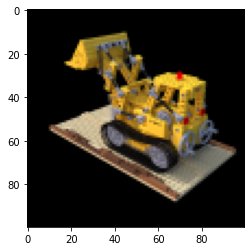

In [10]:
index=15
focal_length=data['focal']
tform_cam2world = torch.tensor(data["poses"][index])
img=data['images'][index]
plt.imshow(img)

## Load up input images, poses, intrinsics, etc.

In [11]:
# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)
# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

#### Display the image used for testing

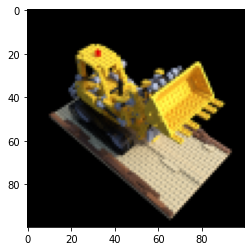

In [12]:
plt.imshow(testimg.detach().cpu().numpy())
plt.show()

## Train TinyNeRF!

In [13]:
class NeuralTangentKernel(torch.nn.Module):
  """
  Neural tangent kernel for positional encoding, taken from https://bmild.github.io/fourfeat/index.html
  """
  def __init__(self,input_dim=3, output_dim=16):
    super(NeuralTangentKernel,self).__init__()
    self.register_parameter('B', torch.nn.Parameter(torch.randn([input_dim,output_dim]).to(device),
                                                     requires_grad=False))
    self.pi = torch.acos(torch.zeros(1)).item() * 2
  def forward(self,x):
    x_proj = (2.*self.pi*x) @ self.B
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], axis=-1)
positional_encoding = NeuralTangentKernel()

In [14]:
# One iteration 
def run_one_step(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             get_minibatches_function,voxel_min=-4,voxel_max=4):
  
  """
  voxel_min and voxel_max refer to the min and max values allowed for the query points.
  By default, assume -4, 4 to be the boundaries of the voxel we sample from
  """
  
  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)
  
  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )
  
  # Normalise to [0,1]
  query_points = (query_points-voxel_min)/(voxel_max-voxel_min) 
  # Normalise to [-1,1]
  query_points = (query_points-0.5)*2 

  # Sample features from voxel grid (trilinear interpolation)
  features = torch.nn.functional.grid_sample(model.voxel.unsqueeze(0),query_points.unsqueeze(0)).squeeze(0)

  # Expand ray directions, and flatten to (-1,3)
  expanded_ray_directions = ray_directions.unsqueeze(0).repeat(features.shape[0],1,1,1).view(-1,3)

  # Add positional encoding
  encoded_ray_directions = positional_encoding(expanded_ray_directions)

  features = torch.movedim(features.view(features.shape[0],-1),0,-1)

  # Combine voxel features and encoded ray directions
  features = torch.cat([features,encoded_ray_directions],dim=-1)

  batches = get_minibatches_function(features, chunksize=chunksize)
  predictions = []

  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, depth_map, acc_map = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted, depth_map, acc_map

Model
TinyVoxelNerf(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=4, bias=True)
  )
)


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Loss: 0.1762089878320694


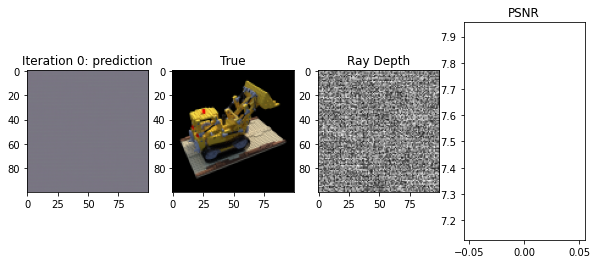

Loss: 0.012285896576941013


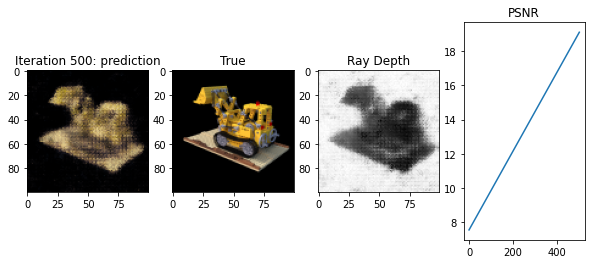

Loss: 0.007415430620312691


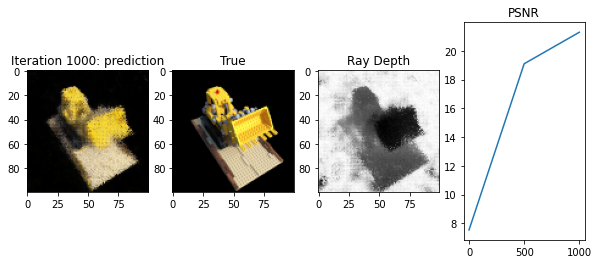

Loss: 0.007535884156823158


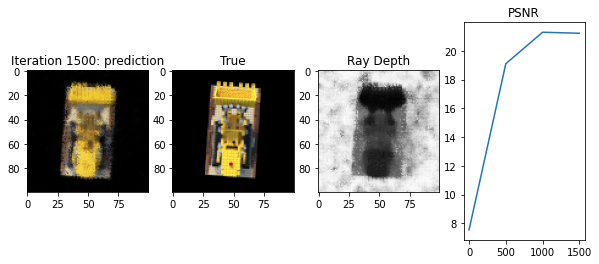

Loss: 0.005729266908019781


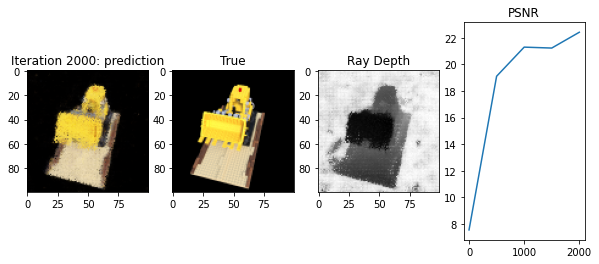

Loss: 0.004398286808282137


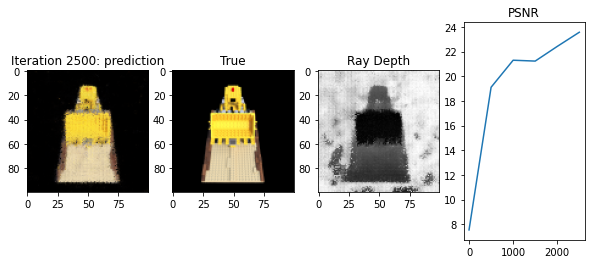

Loss: 0.005458435975015163


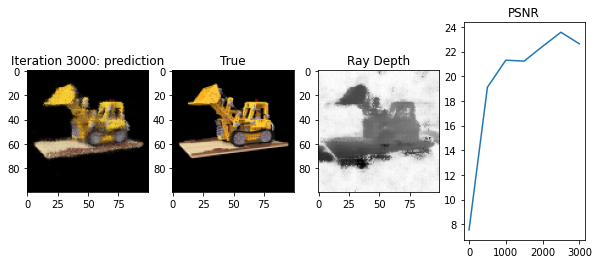

Loss: 0.004702454898506403


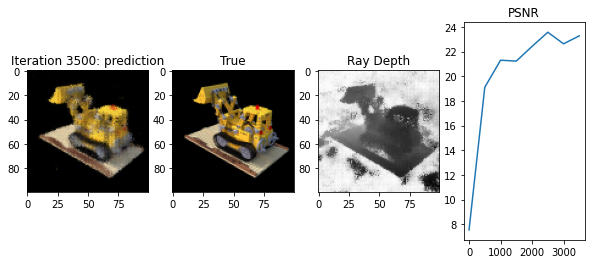

Loss: 0.004565706476569176


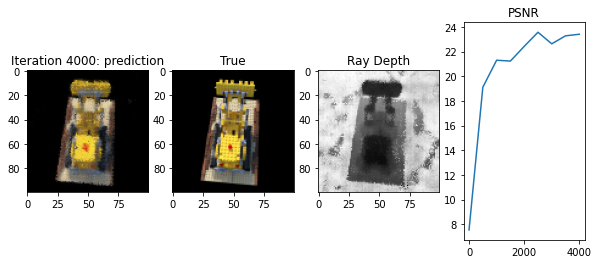

Loss: 0.0023815163876861334


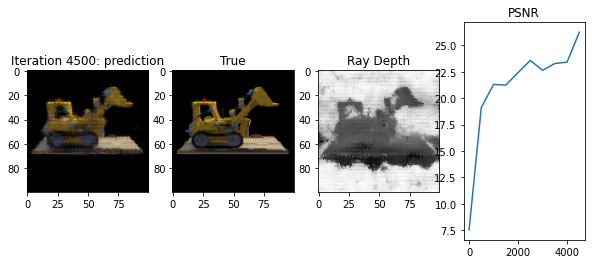

Loss: 0.0024533357936888933


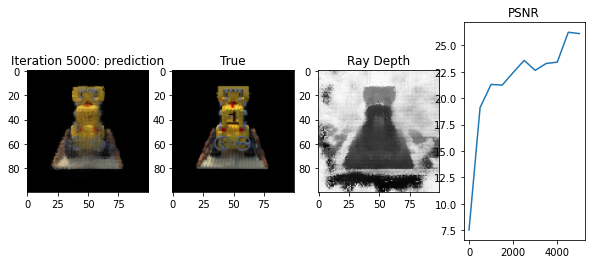

Loss: 0.002972567221149802


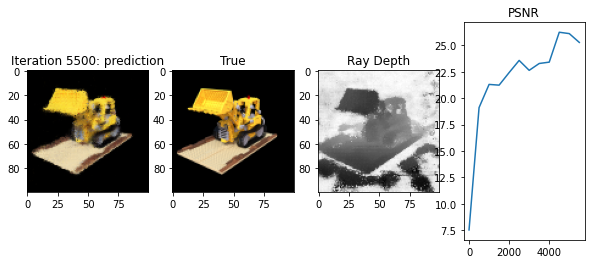

Loss: 0.002267621923238039


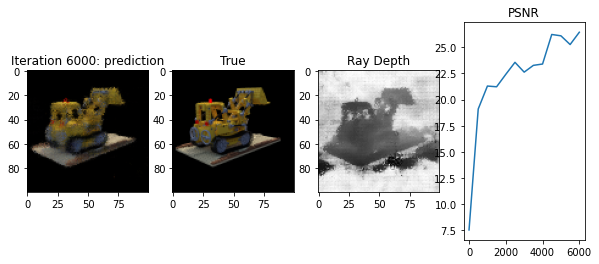

Loss: 0.00454015051946044


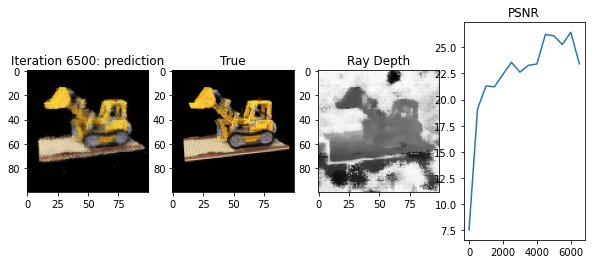

Loss: 0.002625197870656848


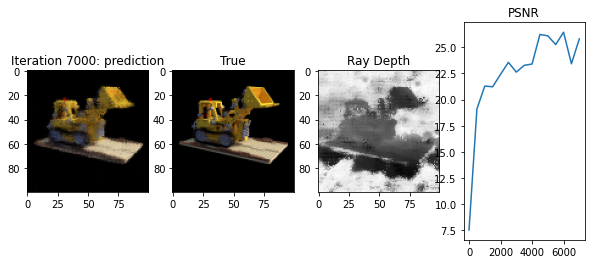

Loss: 0.0041253757663071156


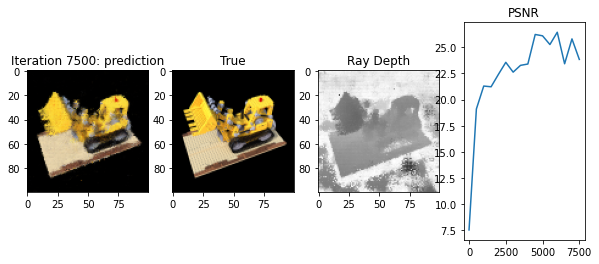

Loss: 0.0027206512168049812


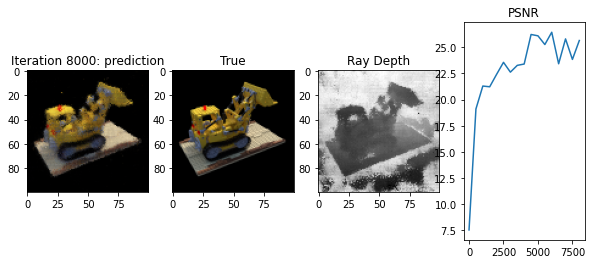

Loss: 0.002471758984029293


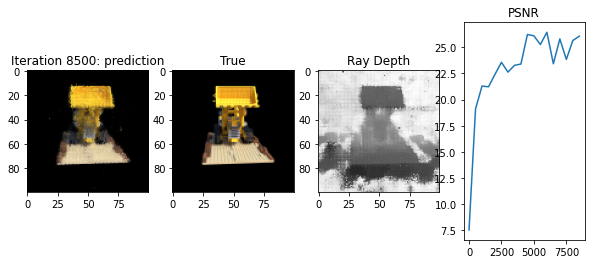

Loss: 0.0023730811662971973


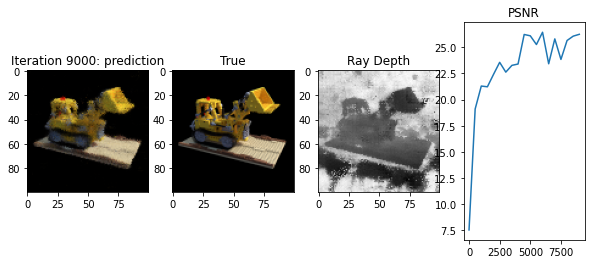

Loss: 0.003583901096135378


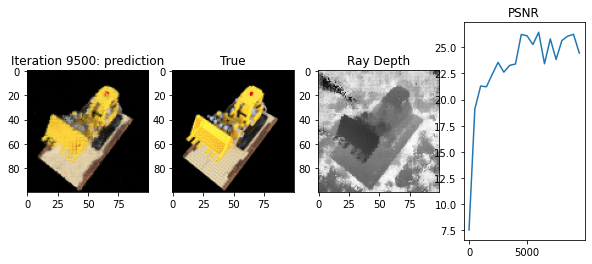

Done!


In [15]:
"""
Parameters for training
"""
# Number of depth samples along each ray.
depth_samples_per_ray = 32

chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 10000

# Misc parameters
display_every = 500  

"""
Model
"""
model = TinyVoxelNerf()
model.to(device)
print("Model")
print(model)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

for i in range(num_iters):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted,_,_ = run_one_step(height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted,depth_map,_ = run_one_step(height, width, focal_length,
                                             target_tform_cam2world, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)
    
    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    
    plt.subplot(141)
    plt.title(f"Iteration {i}: prediction")
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.subplot(142)
    plt.title("True")
    plt.imshow(target_img.detach().cpu().numpy())
    plt.subplot(143)
    plt.title("Ray Depth")
    plt.imshow(depth_map.detach().cpu().numpy(),cmap='gray')
    plt.subplot(144)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')